<a href="https://colab.research.google.com/github/Lubricy/notebooks/blob/master/albert-tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install bert-for-tf2
!pip install sentencepiece

     |████████████████████████████████| 40kB 4.0MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.13.4-cp36-none-any.whl size=29944 sha256=11461a53055751750576268d3ba859bf6fa606d7a35d3ee81fa645743f4d21ff
  Stored in directory: /root/.cache/pip/wheels/d1/14/6d/b36f1618f939480ce5baa48e4d918ea00669f1cbbec4419514
  Created wheel for py-params: filename=py_params-0.8.2-cp36-none-any.whl size=4635 sha256=ccd90032a2b81117188af509cad9e67f581ec7214a015205f18ee9ff2cb993e0
  Stored in directory: /root/.cache/pip/wheels/83/3a/9c/baf35d6f17f0c2c6b61bf8ac3ab9fc12df0e41432ccaeecacb
  Created wheel for params-flow: filename=params_flow-0.7.4-cp36-none-any.whl size=16195 sha256=1d86ebc0169f3290abf3584e0c4785bb6032758ef8137c826df1a3cc5f706fc7
  Stored in directory: /root/.cache/pip/wheels/86/30/40/507b60d68b67ac87f35e95c98f5b296a32f146d5ae1d1d5aa7
Successfully built bert-for-tf2 py-params params-flow
     |████████████████████████████████| 1.0MB 9.4MB/s 


In [3]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_probability as tfp

import tensorflow_hub as hub
import sentencepiece as spm
import bert

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.version.VERSION)
print(tf.test.gpu_device_name())

TensorFlow 2.x selected.
2.1.0
/device:GPU:0


In [5]:
from google.colab import files
uploaded = files.upload()

Saving des.csv to des.csv


In [6]:
df = pd.read_csv('des.csv', header=None, names=['name','desc'], dtype = {"name" : "category", 'desc': 'object'})
df.loc[:, 'proj'] = df['name'].str.split('/').map(lambda s: s[0]).astype('category')
display(df.count())
data = df.dropna()
display(data.count())

name    3064
desc    2453
proj    3064
dtype: int64

name    2453
desc    2453
proj    2453
dtype: int64

In [0]:
 accounts = ['0xProject', 'AugurProject', 'BTCGPU', 'Bitcoin-ABC', 'Coinbene',
       'CyberMiles', 'EOSIO', 'ExchangeUnion', 'Groestlcoin', 'HcashOrg',
       'LiskHQ', 'NebulousLabs', 'NemProject', 'SelfKeyFoundation', 'aragon',
       'binance-exchange', 'bitcoin', 'bitshares', 'brave-intl', 'dashpay',
       'decentraland', 'decred', 'dogecoin', 'ethereum', 'ethereumproject',
       'gifto-io', 'icon-project', 'infinity-economics', 'input-output-hk',
       'iotaledger', 'litecoin-project', 'makerdao', 'mithio',
       'monacocoin-net', 'monero-project', 'nanocurrency', 'neo-project',
       'numerai', 'omisego', 'ontio', 'qtumproject', 'ripple', 'steemit',
       'stellar', 'tetherto', 'tezos', 'tronprotocol', 'trusttoken', 'vechain',
       'wavesplatform', 'zcash']

In [78]:
data['proj'].cat.categories

Index(['0xProject', 'AugurProject', 'BTCGPU', 'Bitcoin-ABC', 'Coinbene',
       'CyberMiles', 'EOSIO', 'ExchangeUnion', 'Groestlcoin', 'HcashOrg',
       'LiskHQ', 'NebulousLabs', 'NemProject', 'SelfKeyFoundation', 'aragon',
       'binance-exchange', 'bitcoin', 'bitshares', 'brave-intl', 'dashpay',
       'decentraland', 'decred', 'dogecoin', 'ethereum', 'ethereumproject',
       'gifto-io', 'icon-project', 'infinity-economics', 'input-output-hk',
       'iotaledger', 'litecoin-project', 'makerdao', 'mithio',
       'monacocoin-net', 'monero-project', 'nanocurrency', 'neo-project',
       'numerai', 'omisego', 'ontio', 'qtumproject', 'ripple', 'steemit',
       'stellar', 'tetherto', 'tezos', 'tronprotocol', 'trusttoken', 'vechain',
       'wavesplatform', 'zcash'],
      dtype='object')

In [7]:
BATCH_SIZE = 32
PADDING_SIZE = 128

albert_layer = hub.KerasLayer(
      "https://tfhub.dev/google/albert_large/3", 
      signature='tokens', 
      output_key='pooled_output', 
      trainable=False)

spm_model_path = albert_layer.resolved_object.asset_paths[2].asset_path.numpy()
sp = spm.SentencePieceProcessor()
sp.load(spm_model_path)
do_lower_case = True

def text2id(text):
  processed_text = bert.albert_tokenization.preprocess_text(text, lower=do_lower_case)
  return bert.albert_tokenization.encode_ids(sp, processed_text)

def build_model():
  input_word_ids = tf.keras.layers.Input(
      shape=(PADDING_SIZE,), dtype=tf.int32, name='input_ids')
  input_mask = tf.keras.layers.Input(
      shape=(PADDING_SIZE,), dtype=tf.int32, name='input_mask')
  input_type_ids = tf.keras.layers.Input(
      shape=(PADDING_SIZE,), dtype=tf.int32, name='segment_ids')
  
  return tf.keras.Model({
      'input_ids': input_word_ids,
      'input_mask': input_mask,
      'segment_ids': input_type_ids
  },
  albert_layer({
      'input_ids': input_word_ids,
      'input_mask': input_mask,
      'segment_ids': input_type_ids
  }))
model = build_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
def token2input(tokens, name):
  return (
    dict( 
        input_ids=tokens,
        input_mask=tf.ones_like(tokens),
        segment_ids=tf.ones_like(tokens))
    , name)

processed_dataset = tf.data.Dataset.from_generator(
    lambda: zip(data['desc'].map(text2id), data['name']),  
    output_types=(tf.int32, tf.string))\
.map(token2input)\
.padded_batch(
      BATCH_SIZE, 
      padded_shapes=({
          'input_ids': (PADDING_SIZE,), 
          'input_mask': (PADDING_SIZE,),
          'segment_ids': (PADDING_SIZE,) 
          }, ()))
next(iter(processed_dataset))

({'input_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
  array([[  713,   396, 11358, ...,     0,     0,     0],
         [   21,  2801,  6123, ...,     0,     0,     0],
         [   21, 15421,     9, ...,     0,     0,     0],
         ...,
         [   21,  1935, 12613, ...,     0,     0,     0],
         [ 1279,    13,    62, ...,     0,     0,     0],
         [   13,     1, 15015, ...,     0,     0,     0]], dtype=int32)>,
  'input_mask': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
  'segment_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         

In [0]:
res = model.predict(processed_dataset)

In [61]:
res.shape

(2453, 1024)

In [0]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score
ari = adjusted_rand_score


def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [0]:
from sklearn.cluster import KMeans
y = data['proj'].cat.codes.values
n_clusters = 3
# Runs in parallel 4 CPUs
kmeans = KMeans(n_clusters=n_clusters, n_init=20, n_jobs=4)
# Train K-Means.
y_pred_kmeans = kmeans.fit_predict(res)
# Evaluate the K-Means clustering accuracy.
#acc(y, y_pred_kmeans)

In [92]:
vis[vis['proj'] == 'ethereum'][vis['y_pred'] == 0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,name,desc,proj,x,y,y_pred
1312,ethereum/UniversalLoginSDK,Universal Login SDK,ethereum,41.257038,-29.620914,0
1328,ethereum/cable,Cable: CMake Bootstrap Library,ethereum,39.005096,-28.885876,0
1333,ethereum/cpp-build-env,Docker images for building C++ projects,ethereum,54.186432,-18.152031,0
1334,ethereum/cpp-dependencies,"download, compile && prepare cpp-ethereum depe...",ethereum,51.883663,-28.093906,0
1347,ethereum/dopple,Dopple: JSON-RPC Proxy Server,ethereum,50.267277,-17.930857,0
1361,ethereum/eth-rlp,STUB,ethereum,46.120159,-32.419159,0
1369,ethereum/eth2.0-metrics,Informative spec for ETH 2.0 metrics,ethereum,52.634235,-26.734585,0
1373,ethereum/eth2.0-specs,Ethereum 2.0 Specifications,ethereum,53.430897,-15.131763,0
1380,ethereum/ethereum-buildbot,Ethereum Buildbot,ethereum,50.205795,-12.288957,0
1388,ethereum/ethereum-ppa,Ethereum PPA configurations,ethereum,48.499790,-5.364083,0


In [0]:
from sklearn.manifold import TSNE
t_sne = TSNE(n_components=2).fit_transform(res)

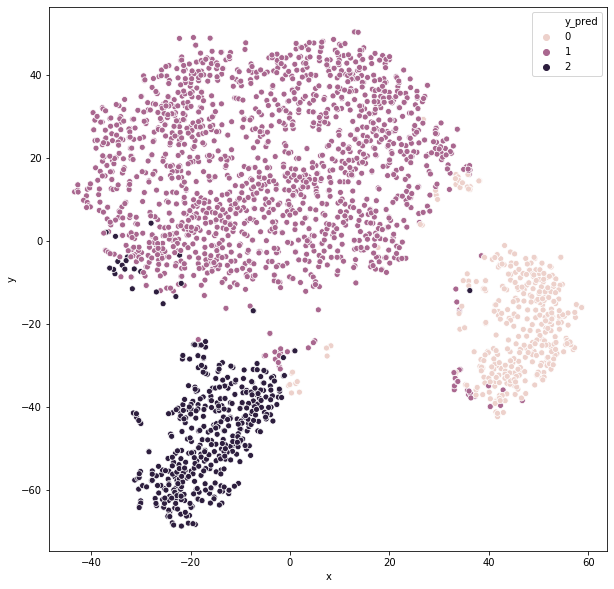

In [14]:
import seaborn as sns
vis = data.copy()
vis.loc[:, 'x'] = t_sne[:, 0]
vis.loc[:, 'y'] = t_sne[:, 1]
vis.loc[:, 'y_pred'] = y_pred_kmeans
plt.figure(figsize=(10,10))
sns.scatterplot(data=vis, x='x', y='y', hue='y_pred')

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=.65, min_df=1, stop_words=None, use_idf=True, norm=None)
transformed_documents = vectorizer.fit_transform(vis['desc'])

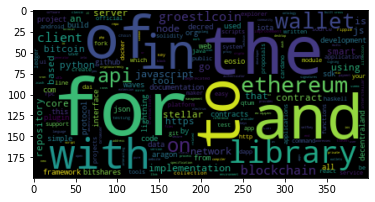

In [72]:
tfidf = dict(zip(vectorizer.get_feature_names(), np.asarray(transformed_documents.sum(axis=0)).reshape(-1)))
whole = WordCloud().generate_from_frequencies(frequencies=tfidf)
plt.imshow(whole, interpolation='bilinear')
plt.show()

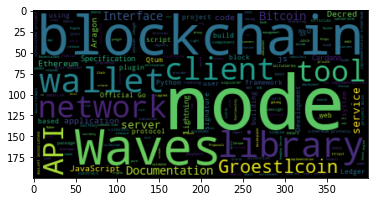

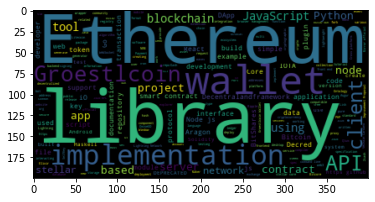

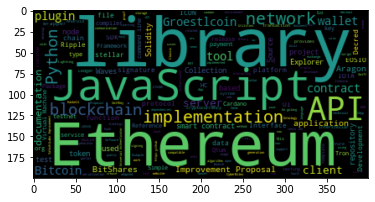

In [35]:
from wordcloud import WordCloud
for i in range(3):
  wordcloud = WordCloud().generate('\n'.join(vis[vis['y_pred'] == i]['desc']))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.show()